In [1]:
import numpy as np, healpy as hp, pickle
from matplotlib.pyplot import *
# from cmblensplus
import curvedsky, constants, cmb, misctools, quad_func, plottools as pl
# local
import prjlib

In [2]:
def genalm(rlz,film,lmax,nside,bl,nl,W,folm,fnlm,simtype,ow=False):
    for i in rlz:
        misctools.progress(i,rlz)
        if misctools.check_path(folm[i],overwrite=ow): continue
        Tilm = pickle.load(open(film[i],"rb"))[:lmax+1,:lmax+1]
        if simtype == 'bla':
            nalm = 0.*Tilm
        else:
            nalm = curvedsky.utils.gauss1alm(lmax,nl)
        Tolm = curvedsky.utils.mulwin(nside,lmax,lmax,Tilm*bl[:,None]+nalm,W) / bl[:,None]
        pickle.dump((Tolm),open(folm[i],"wb"),protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump((nalm),open(fnlm[i],"wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
def cninv(rlz,film,fnlm,lmax,nside,bl,lcl,M,W,fwlm,ow=False,itns=[1000],eps=['1e-5'],stat='test.dat'):
    npix = 12*nside**2
    for i in rlz:
        misctools.progress(i,rlz)
        if misctools.check_path(fwlm[i],overwrite=ow): continue
        Tilm = pickle.load(open(film[i],"rb"))[:lmax+1,:lmax+1] 
        nalm = pickle.load(open(fnlm[i],"rb"))[:lmax+1,:lmax+1] 
        Tdat = np.reshape( M * curvedsky.utils.hp_alm2map(nside,lmax,lmax,Tilm*bl[:,None]+nalm) , (1,1,npix) )
        Nij  = np.reshape( W * (sigma*(np.pi/10800.)/Tcmb)**(-2) , (1,1,npix) )
        Twlm = curvedsky.cninv.cnfilter_freq(1,1,npix,lmax,lcl[0:1,:lmax+1],np.reshape(bl,(1,lmax+1)),Nij,Tdat,1,itns=itns,eps=eps,filter='W',ro=1,stat=stat)
        pickle.dump((Twlm),open(fwlm[i],"wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
def comp_cmbcls(rlz,lmax,wn,film,folm,fcl):
    cl = np.zeros((2,len(rlz),lmax+1))
    for i in rlz:
        Tolm = pickle.load(open(folm[i],"rb"))[:lmax+1,:lmax+1]
        Tilm = pickle.load(open(film[i],"rb"))[:lmax+1,:lmax+1] 
        ii = i - np.min(rlz)
        cl[0,ii,:] = curvedsky.utils.alm2cl(lmax,Tolm)/wn[2]
        cl[1,ii,:] = curvedsky.utils.alm2cl(lmax,Tolm,Tilm)/wn[1]
    l = np.linspace(0,lmax,lmax+1)
    np.savetxt(fcl,np.concatenate((l[None,:],np.mean(cl,axis=1))).T)

In [5]:
def plot_cmbcls(fctt,lcl,nlbl,method):
    l, Too, Toi = np.loadtxt(fctt,unpack=True)
    pl.plot_1dstyle(ylog=True,ymin=1e-11,ymax=1e-8,ylab='$L^2C_L^{TT}$')
    yscale('log')
    plot(l**2*Too,label='obs')
    plot(l**2*Toi,label='cross',lw=2)
    plot(l**2*lcl[0,:],label='input',color='k',ls='--',lw=1)
    plot(l**2*lcl[0,:]**2/(lcl[0,:]+nlbl),label='theory',color='k',lw=1)
    plot(l**2*(lcl[0,:]+nlbl),label='theory (s+o)',color='k',lw=1)
    legend()
    savefig('fig_ctt_'+method+'.png')
    show()

In [6]:
def comp_mklm(rlz,fklm,lmax):
    mklm = 0.
    for i in rlz:
        klm = pickle.load(open(fklm[i],"rb"))[0][:lmax+1,:lmax+1]
        mklm += klm/len(rlz)
    return mklm

In [7]:
def comp_clkk(rlz,fklm,fplm,lmax,wn,fckk):
    mklm = comp_mklm(rlz,fklm,lmax)
    kk = np.zeros((4,len(rlz),lmax+1))
    for i in rlz:
        if i==1: print(fklm[i])
        klm = pickle.load(open(fklm[i],"rb"))[0][:lmax+1,:lmax+1]
        iklm = prjlib.load_input_plm(fplm[i],lmax,ktype='k')
        ii = i - np.min(rlz)
        kk[0,ii,:] = curvedsky.utils.alm2cl(lmax,klm)/wn[4]
        kk[1,ii,:] = curvedsky.utils.alm2cl(lmax,klm,iklm)/wn[2]
        kk[2,ii,:] = curvedsky.utils.alm2cl(lmax,iklm)
    mkk = np.mean(kk,axis=1)
    mkk[3,:] = curvedsky.utils.alm2cl(lmax,mklm)/wn[4]
    L = np.linspace(0,lmax,lmax+1)
    np.savetxt(fckk,np.concatenate((L[None,:],mkk)).T)

In [27]:
def plot_ckk(pqf,fckk,method):
    L, n0 = np.loadtxt(pqf.n0bs,unpack=True,usecols=(0,1))
    e, N0 = np.loadtxt(pqf.n0bs.replace('_so','').replace('n005','n050'),unpack=True,usecols=(0,1))
    L, al = np.loadtxt(pqf.al,unpack=True,usecols=(0,1))
    l, rkk, xkk, ikk, mkk = np.loadtxt(fckk,unpack=True)
    pl.plot_1dstyle(xlog=True,ylog=True,xmin=2,xmax=2000,ymin=1e-8,ymax=1e-2,ylab='$C_L^{\kappa\kappa}$')
    plot(L,n0,label='N0')
    plot(e,N0,label='N0')
    plot(L,al,label='Norm')
    plot(l,rkk,label=r'$C^{\hat{\kappa}\hat{\kappa}}_L$')
    plot(l,mkk,label=r'Mean-field')
    plot(l,rkk-mkk-.9*n0[:len(l)],'k-',label=r'$C^{\hat{\kappa}\hat{\kappa}}_L$ - Mean - N0')
    plot(l,xkk,label=r'cross with input')
    plot(l,ikk,label=r'input')
    figtext(.1,.5,str(rlmin)+r'$\leq \ell_{\rm cmb}\leq$'+str(rlmax))
    legend(loc=1)
    savefig('fig_ckk_'+method+'.png')
    show()

In [9]:
def qrec(p,fcmbaps,lmax,lcl,wn,falm,fplm,fckk,exttag='',ow=False,rlmin=500,rlmax=2048,method='diag'):
    l, Tww, Twi = np.loadtxt(fcmbaps,unpack=True)
    ifl = np.zeros((3,lmax+1))
    ocl = np.zeros((4,lmax+1))
    if method == 'cinv':
        alp = np.zeros((3,lmax+1))
        alp[0,2:] = Twi[2:]/lcl[0,2:]
        ocl[0,2:] = Tww[2:]/alp[0,2:]**2
        ifl[0,2:] = Tww[2:]/alp[0,2:]
    else:
        ocl[0,:] = Tww
        ifl[0,:] = Tww
    quad = prjlib.quad_init(p.ids,p.stag+exttag,wn=wn,lcl=lcl,ocl=ocl,ifl=ifl,falm=falm,rlmin=rlmin,rlmax=rlmax,n0max=5,qlist=['TT'])
    quad_func.qrec_flow(quad,p.snmin,p.snmax,donorm=True,doqrec=True,don0=True,dordn0=False,domean=False,overwrite=ow)
    comp_clkk(p.rlz,quad.f['TT'].alm,fplm,quad.oLmax,wn,fckk)
    plot_ckk(quad.f['TT'],fckk,method)
    return quad

In [10]:
def setup_filename(simtype,method,snmax,D='../../data/sodelens/trash/qrec/'):
    exttag='_'+simtype+'_'+method
    fctt = D+'cmb_aps'+exttag+'.dat'
    fckk = D+'../../lens/aps/ckk_o'+exttag+'.dat'
    fnlm, folm = {}, {}
    fnlm['T'] = np.array([D+'cmb_nlm'+exttag+'_'+str(i).zfill(2)+'.pkl' for i in range(0,snmax+1)])
    folm['T'] = np.array([D+'cmb_olm'+exttag+'_'+str(i).zfill(2)+'.pkl' for i in range(0,snmax+1)])
    return exttag, fctt, fnlm, folm, fckk

In [11]:
#simtype = 'plk' # binary mask + plk white noise
#simtype = 'bla' # binary mask
simtype = 'so'
lmax = 3000
rlmin, rlmax = 500, 3000
#method = 'diag'
method = 'cinv'
p = prjlib.analysis_init(t='la',freq='coadd',snmin=1,snmax=10,lmax=lmax)
pid = prjlib.analysis_init(t='id',ntype='cv',snmin=1,snmax=10,lmax=lmax)
exttag, fctt, fnlm, folm, fkk = setup_filename(simtype,method,p.snmax)
if simtype=='so': folm['T'] = np.array(['../../data/sodelens/trash/T_lcoadd_'+str(i).zfill(3)+'.pkl' for i in range(101)])

In [12]:
if simtype=='bla':
    bl = np.ones(lmax+1)
    sigma = 0.
elif simtype=='so':
    bl = 1./cmb.beam(1.,lmax)
    sigma = 10.
else:
    bl = 1./cmb.beam(7.,lmax)
    sigma = 30.
nl = (sigma*(np.pi/10800.)/2.72e6)**2 * np.ones(lmax+1)

In [13]:
W, M, wn = prjlib.window('la',p.nside)
#WN = np.ones(5)*wn[0]

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
fsky and normalization corrections: [0.5752538  0.14110665 0.04651988 0.01847941 0.008786  ]


In [14]:
# output mask
#hp.fitsfunc.write_map('la_n2048_binary.fits',M)
#hp.mollview(M)

In [15]:
if simtype in ['plk','bla']: #binary mask
    wn[:] = wn[0]
    W = 1.*M
if simtype == 'so':
    #wn = np.ones(5)
    wn[:] = wn[0]

In [16]:
if method=='diag':
    genalm(p.rlz,pid.fcmb.alms['o']['T'],p.lmax,p.nside,bl,nl,W,folm['T'],fnlm['T'],simtype,ow=False)

In [17]:
if simtype!='so' and method=='cinv':
    cninv(p.rlz,pid.fcmb.alms['o']['T'],fnlm['T'],p.lmax,p.nside,bl,p.lcl,M,W,folm['T'],ow=False)

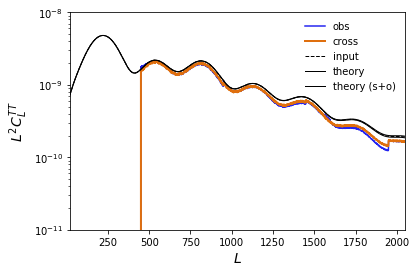

In [20]:
comp_cmbcls(p.rlz,p.lmax,wn,pid.fcmb.alms['o']['T'],folm['T'],fctt)
#comp_cmbcls(p.rlz,p.lmax,wn,pid.fcmb.alms['o']['T'],folm['T'],fwlm['T'],fcmbaps)
plot_cmbcls(fctt,p.lcl,nl/bl**2,method)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


/project/projectdirs/sobs/delensing/lens/aps/Al_TT_lacoadd_base_so_cinv_l500-3000.dat exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0001.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0002.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0003.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0004.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0005.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0006.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/lens/alm/alm_TT_lacoadd_base_so_cinv_l500-3000_0007.pkl exist and is not overwritten
/project/projectdirs/sobs/delensing/le

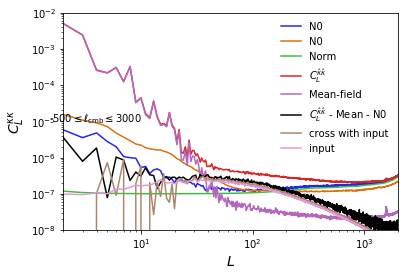

In [28]:
q0 = qrec(p,fctt,p.lmax,p.lcl,wn,folm,p.fpalm,fkk,exttag=exttag,method=method,rlmin=rlmin,rlmax=rlmax,ow=False)

In [ ]:
m = hp.ud_grade(M,64)

In [ ]:
Lmax = 100
nside = 64
klm = pickle.load(open(q0.f['TT'].alm[1],"rb"))[0][:Lmax+1,:Lmax+1]
kap = curvedsky.utils.hp_alm2map(64,Lmax,Lmax,klm)/wn[2]
hp.mollview(kap,min=-.5,max=.29)
savefig('fig_kap_plk.png')

In [ ]:
mklm = comp_mklm(p.rlz,q0.f['TT'].alm,Lmax)
#klm = pickle.load(open(q0.f['TT'].mf,"rb"))[0][:Lmax+1,:Lmax+1]
mkap = curvedsky.utils.hp_alm2map(nside,Lmax,Lmax,mklm)/wn[2]
hp.mollview(mkap,min=-.5,max=.29)
savefig('fig_mkap_plk.png')

In [ ]:
hp.mollview(kap-mkap,min=-.5,max=.29)
savefig('fig_dkap_plk.png')

In [ ]:
hp.mollview(m,min=.99,max=1.)